# Natural Language Processing. Assignment 1. Tokenization.

In this assignment, you need to implement, train, and analyze a Byte-Pair Encoding (BPE) tokenizer.

The assignment consist of 3 tasks. When you finish all the tasks, create a GitHub repository for this assignment (you can use this repository later for the other assignments) and submit this notebook in the repository. Leave `requirements.txt` file if your code requires additional installations. Submit the link to the repository in Moodle.

## Task 1: Data Preparation and Vocabulary Size Selection (3 points)

First, load the [Brown corpus](https://en.wikipedia.org/wiki/Brown_Corpus). After loading the corpus, you need to select the appropriate vocabulary size for the BPE tokenizer. The appropriate vocabulary size is the minimal vocabulary size that covers at least 90% of the words in the corpus. The coverage is calculated according to the following formula:



$$ \text{coverage}(k) = \frac{\sum_{r=1}^{k} f(r)}{\sum_{r=1}^{N} f(r)} $$



where $f(r)$ is the frequency of the top-$r$ word, $k$ is the number of top-$k$ tokens included in vocab, $N$ is the total unique words in corpus.

So, for this task you need to do the following:

1. Load the Brown corpus (0.5 points)
2. Plot cumulative coverage vs. vocabulary size for the loaded corpus (1 point)
3. Select the appropriate vocabulary size (0.5 point)
4. Answer the questions:
    1. Why the coverage slows down the increase as the vocabulary size increases? (0.5 point)
    2. Which empirical law explains the slowing down increase of the coverage? (0.5 point)

Loaded 57,340 sentences
Total tokens: 1,161,192
Vocabulary size (unique word types): 49,815


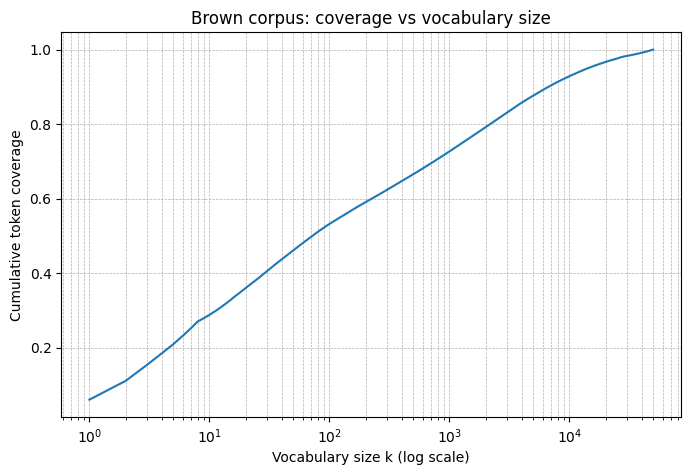

Smallest k achieving ≥ 90% coverage: k90 = 6,671
Coverage at k90: 0.9000


In [1]:
from __future__ import annotations

from collections import Counter
from dataclasses import dataclass
from typing import Iterable, List, Tuple

import math
import numpy as np
import matplotlib.pyplot as plt

def _load_brown_sentences() -> List[List[str]]:
    """
    Load tokenized sentences from the NLTK Brown corpus.

    If the corpus is unavailable (e.g., no NLTK data installed and no internet),
    fall back to a small built-in sample so the notebook remains runnable.
    """
    try:
        import nltk
        from nltk.corpus import brown

        # Try to access corpus; if missing, attempt download.
        try:
            _ = brown.sents()[:1]
        except LookupError:
            nltk.download("brown", quiet=True)
            nltk.download("punkt", quiet=True)  # some setups require tokenizers
        return [list(map(str, sent)) for sent in brown.sents()]
    except Exception as e:
        # Fallback: small sample (keeps pipeline functional without external data).
        sample = [
            "This is a small fallback corpus used when Brown is unavailable .",
            "It is not representative but allows the code to run end-to-end .",
            "Tokenization assignments should ideally run on the real Brown corpus .",
        ]
        return [s.split() for s in sample]

# 1) Load Brown corpus
sentences = _load_brown_sentences()

# Build a frequency distribution over word types.
# Lowercasing to reduce vocabulary inflation due to case.
tokens = [w.lower() for sent in sentences for w in sent]
freq = Counter(tokens)

total_tokens = sum(freq.values())
vocab_size = len(freq)
print(f"Loaded {len(sentences):,} sentences")
print(f"Total tokens: {total_tokens:,}")
print(f"Vocabulary size (unique word types): {vocab_size:,}")

# 2) Plot cumulative coverage vs vocabulary size.
# Coverage(k) = fraction of token occurrences covered by the k most frequent word types.
sorted_counts = np.array([c for _, c in freq.most_common()], dtype=np.int64)
cumulative = np.cumsum(sorted_counts)
coverage = cumulative / cumulative[-1]
k = np.arange(1, len(sorted_counts) + 1)

plt.figure(figsize=(8, 5))
plt.plot(k, coverage)
plt.xscale("log")  # standard to visualize Zipf-like distributions
plt.xlabel("Vocabulary size k (log scale)")
plt.ylabel("Cumulative token coverage")
plt.title("Brown corpus: coverage vs vocabulary size")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

# 3) Select the appropriate vocabulary size (>= 90% coverage)
target_coverage = 0.90
k90 = int(np.searchsorted(coverage, target_coverage) + 1)  # +1 because k starts from 1
print(f"Smallest k achieving ≥ {target_coverage:.0%} coverage: k90 = {k90:,}")
print(f"Coverage at k90: {coverage[k90-1]:.4f}")

**Q1.** Why does coverage slow down as vocabulary size increases?

Because word frequencies follow a heavy-tailed (Zipf-like) distribution, where a small number of very frequent words account for most token occurrences. After those are included, adding more word types mostly adds rare words, so the marginal gain in covered token mass becomes small.

**Q2.** 2. Which empirical law explains the slowing down increase of the coverage?

The empirical law that explains the slowing down increase of coverage is Zipf’s Law.

## Task 2: Implement Byte-Pair Encoding (BPE) Tokenizer (4 points)

Implement the [BPE tokenizer](https://arxiv.org/pdf/1508.07909) as the `BPETokenizer` class.

The class should contain correctly implemented:

* `train` method (1.5 points).
* `tokenize` method (1.5 points).

The code should have docstrings and comments (1 point).

In [2]:
from __future__ import annotations

from collections import Counter, defaultdict
from dataclasses import dataclass
from typing import Dict, Iterable, List, Sequence, Tuple

import re


Pair = Tuple[str, str]
Symbols = Tuple[str, ...]


class BPETokenizer:
    """
    Byte-Pair Encoding (BPE) tokenizer (subword segmentation).

    This implementation follows the core idea from Sennrich et al. (2016):
    iteratively merge the most frequent adjacent symbol pair in a corpus.

    Notes:
    - We train on word types with counts (weighted by token frequency).
    - Words are represented as tuples of symbols: characters + an end-of-word marker '</w>'.
      This prevents merges across word boundaries during training and tokenization.
    - Tokenization applies merges in the order learned during training.
    """

    def __init__(self, end_of_word: str = "</w>") -> None:
        self.end_of_word = end_of_word
        self.merges: List[Pair] = []
        self.merge_ranks: Dict[Pair, int] = {}  # lower rank => earlier merge
        self.trained: bool = False

    @staticmethod
    def _word_to_symbols(word: str, end_of_word: str) -> Symbols:
        """Convert a single word into an initial symbol sequence (chars + </w>)."""
        # Keep it simple: assume `word` is already normalized (e.g., lowercase).
        return tuple(list(word) + [end_of_word])

    @staticmethod
    def _get_pairs(symbols: Sequence[str]) -> set[Pair]:
        """Return the set of adjacent symbol pairs in the sequence."""
        return set(zip(symbols[:-1], symbols[1:]))

    @staticmethod
    def _merge_pair(symbols: Sequence[str], pair: Pair) -> Symbols:
        """
        Merge all occurrences of `pair` in `symbols` into a single concatenated symbol.

        Example: symbols = ["l", "o", "w", "</w>"], pair=("l","o") -> ["lo", "w", "</w>"]
        """
        merged: List[str] = []
        i = 0
        a, b = pair
        while i < len(symbols):
            if i < len(symbols) - 1 and symbols[i] == a and symbols[i + 1] == b:
                merged.append(a + b)
                i += 2
            else:
                merged.append(symbols[i])
                i += 1
        return tuple(merged)

    def train(self, corpus: Iterable[str], vocab_size: int) -> None:
        """
        Train BPE merges on the given corpus.

        Parameters
        ----------
        corpus:
            Iterable of raw text strings (sentences/documents). We split on whitespace.
            If you want a more sophisticated pre-tokenization, do it before calling train.
        vocab_size:
            Target vocabulary size (approximate). Training stops when the number of unique
            symbols reaches this value or no more merges are possible.

        The learned merges are stored in:
        - self.merges (ordered list)
        - self.merge_ranks (pair -> rank)
        """
        if vocab_size <= 0:
            raise ValueError("vocab_size must be a positive integer")

        # 1) Build word frequency distribution from corpus.
        word_freq: Counter[str] = Counter()
        for text in corpus:
            for w in text.split():
                w = w.lower()
                if not w:
                    continue
                word_freq[w] += 1

        # 2) Initialize words as character sequences with end-of-word.
        vocab: Dict[Symbols, int] = {
            self._word_to_symbols(word, self.end_of_word): count
            for word, count in word_freq.items()
        }

        # Helper: count symbol vocabulary size.
        def current_symbol_vocab_size(vocab_dict: Dict[Symbols, int]) -> int:
            sym_set = set()
            for sym_seq in vocab_dict.keys():
                sym_set.update(sym_seq)
            return len(sym_set)

        # Reset any previous training state.
        self.merges = []
        self.merge_ranks = {}
        self.trained = False

        # 3) Iteratively perform merges.
        while True:
            sym_vocab_size = current_symbol_vocab_size(vocab)
            if sym_vocab_size >= vocab_size:
                break

            # Count all adjacent pairs weighted by word frequency.
            pair_counts: Dict[Pair, int] = defaultdict(int)
            for sym_seq, count in vocab.items():
                for pair in zip(sym_seq[:-1], sym_seq[1:]):
                    pair_counts[pair] += count

            if not pair_counts:
                break

            # Choose the most frequent pair.
            best_pair = max(pair_counts.items(), key=lambda kv: kv[1])[0]

            # If the best pair occurs only once, further merges won't help much.
            # Still, we can merge; but to keep training meaningful, stop if too rare.
            if pair_counts[best_pair] < 2:
                break

            # Apply the merge to all vocabulary entries.
            new_vocab: Dict[Symbols, int] = {}
            for sym_seq, count in vocab.items():
                merged_seq = self._merge_pair(sym_seq, best_pair)
                new_vocab[merged_seq] = new_vocab.get(merged_seq, 0) + count

            vocab = new_vocab
            self.merge_ranks[best_pair] = len(self.merges)
            self.merges.append(best_pair)

        self.trained = True
        print(f"Training finished. Learned merges: {len(self.merges):,}")
        print(f"Final symbol vocab size (approx): {current_symbol_vocab_size(vocab):,}")

    def _apply_bpe(self, word: str) -> List[str]:
        """
        Apply learned BPE merges to a single word and return subword tokens.
        """
        if not self.trained:
            raise RuntimeError("Tokenizer is not trained. Call train() first.")

        symbols: Symbols = self._word_to_symbols(word.lower(), self.end_of_word)

        # If no merges were learned, return chars (without </w>).
        if not self.merges:
            return [s for s in symbols if s != self.end_of_word]

        # Merge iteratively: always merge the pair with the best (lowest) rank present.
        while True:
            pairs = self._get_pairs(symbols)
            if not pairs:
                break

            # Find the highest-priority pair among those present.
            ranked = [(self.merge_ranks.get(p, float("inf")), p) for p in pairs]
            rank, best = min(ranked, key=lambda x: x[0])

            if rank == float("inf"):
                break  # no applicable merges

            symbols = self._merge_pair(symbols, best)

        # Drop end-of-word marker from output
        out = [s for s in symbols if s != self.end_of_word]
        return out

    def tokenize(self, text: str) -> List[str]:
        """
        Tokenize input text into BPE subword tokens.

        We perform a simple whitespace split for pre-tokenization (as in training).
        """
        if not self.trained:
            raise RuntimeError("Tokenizer is not trained. Call train() first.")

        tokens: List[str] = []
        for w in text.split():
            if not w:
                continue
            tokens.extend(self._apply_bpe(w))
        return tokens

## Task 3: Tokenizer Training and Analysis (3 points)

1. Train the `BPETokenizer` on the Brown corpus with the appropriate vocabulary size selected in Task 1 (1 points)
2. Use the Brown corpus (1000 samples) to calculate the mean and standard deviation of
    * tokenizer's fertility (1 points)
    * length of the tokenized sentence (1 points)

In [3]:
import numpy as np

# Prepare training corpus as raw sentences (strings).
train_corpus = [" ".join(sent) for sent in sentences]

tokenizer = BPETokenizer()
tokenizer.train(train_corpus, vocab_size=k90)

# Take 1000 samples from Brown (or fewer if fallback corpus is smaller).
n_samples = min(1000, len(train_corpus))
sample_texts = train_corpus[:n_samples]

fertilities = []
tokenized_lengths = []

for text in sample_texts:
    words = [w for w in text.split() if w]
    if not words:
        continue
    subwords = tokenizer.tokenize(text)

    # Fertility: average #subword tokens per word in the sentence.
    fertility = len(subwords) / len(words)
    fertilities.append(fertility)

    # Length of tokenized sentence: #subword tokens.
    tokenized_lengths.append(len(subwords))

fertilities = np.array(fertilities, dtype=float)
tokenized_lengths = np.array(tokenized_lengths, dtype=float)

print(f"Evaluated on {len(fertilities):,} sentences")
print(f"Fertility: mean={fertilities.mean():.4f}, std={fertilities.std(ddof=1):.4f}")
print(f"Tokenized sentence length: mean={tokenized_lengths.mean():.4f}, std={tokenized_lengths.std(ddof=1):.4f}")

Training finished. Learned merges: 6,678
Final symbol vocab size (approx): 6,671
Evaluated on 1,000 sentences
Fertility: mean=1.2696, std=0.2527
Tokenized sentence length: mean=27.3590, std=15.1009


## Grading Procedure Details

During the grading of the completed assignments, a random set of students will be sampled for the **offline assignment defence**. The defence will be arranged shortly after the assignment submission deadline. The particular date and time will be announced later.

The aim of the assignment defence is to ensure the students understand well their own solutions and know how thier solution works. To check this, the students will be asked various questions about the provided solution. In addition, the students will be asked to run their solution to ensure the solution works without errors.

Examples of questions:

1. How the cumulative coverage is calculated? Why is it called cumulative?
2. What is the rank of a word?
3. How does the BPE tokenizer work? Note: for this question, the students will not be able to see the their own implementation.
4. Why do you consider such vocabulary size appropriate?
5. What is the formula for the fertility of the tokenizer?
6. How do you perform pre-tokenization in your implementation?
7. How do you handle stopwords in the training corpus? Why?
8. etc.

As a result of the assignment defence, the grade for the assignment may be adjusted.